In [1]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = lasio.read("C:\\Users\\sayea5\\PycharmProjects\\NMR\\input_files\\R-540_CMR.las").df().dropna()
del df["TCMR"]
df.describe()

LAS spec version is 3.0 -- neither 1.2 nor 2


,T2DIST_DI_CMR[0],T2DIST_DI_CMR[1],T2DIST_DI_CMR[2],T2DIST_DI_CMR[3],T2DIST_DI_CMR[4],T2DIST_DI_CMR[5],T2DIST_DI_CMR[6],T2DIST_DI_CMR[7],T2DIST_DI_CMR[8],T2DIST_DI_CMR[9],...,T2DIST_DI_CMR[54],T2DIST_DI_CMR[55],T2DIST_DI_CMR[56],T2DIST_DI_CMR[57],T2DIST_DI_CMR[58],T2DIST_DI_CMR[59],T2DIST_DI_CMR[60],T2DIST_DI_CMR[61],T2DIST_DI_CMR[62],T2DIST_DI_CMR[63]
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,0.000863,0.000920,0.000941,0.000932,0.000894,0.000852,0.000821,0.000825,0.000840,0.000847,...,0.001741,0.001549,0.001391,0.001270,0.001190,0.001143,0.001109,0.001100,0.001173,0.001480
std,0.001684,0.001829,0.001910,0.001930,0.001911,0.001874,0.001861,0.001882,0.001931,0.001966,...,0.003000,0.002728,0.002497,0.002310,0.002157,0.002042,0.001963,0.001920,0.002003,0.003500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000136,0.000157
75%,0.001083,0.001186,0.001265,0.001226,0.001181,0.001111,0.000993,0.001051,0.001115,0.001080,...,0.002136,0.001743,0.001489,0.001355,0.001303,0.001305,0.001320,0.001363,0.001490,0.001775
max,0.012909,0.014342,0.015693,0.016455,0.016569,0.016245,0.016757,0.017733,0.018616,0.019078,...,0.015088,0.012975,0.011932,0.012398,0.012861,0.013059,0.012948,0.012518,0.011795,0.054735


In [5]:
from scipy import stats
from scipy.misc import derivative
from scipy.interpolate import splrep, splev

In [6]:
class T2Dist(stats.rv_continuous):
    def __init__(self, t2_min, t2_max, bins, t2_data, clip_point=None):
        """
        Creates a continuous T2 distribution which can be sampled from
        Binned T2 data is converted to a continuous variable using a cubic spline
        :param t2_min: Min extent of T2 e.g. 0.3ms
        :param t2_max: Max extent of T2 e.g. 30000ms
        :param bins: Number of bins in the T2 distribution from the LAS file
        :param t2_data: The T2 values from the LAS file (array of len bins)
        """
        super().__init__(a=np.log10(t2_min), b=np.log10(t2_max))
        time_step = (np.log10(t2_max) - np.log10(t2_min)) / (bins - 1)
        self.log_time = [np.log10(t2_min) + x * time_step for x in range(bins)]
        if clip_point is None:
            self.t2 = t2_data
        else:
            self.t2 = self.clip_data(clip_point, t2_data)

    def _cdf(self, x, *t2_data):
        tck = splrep(self.log_time, self.t2.cumsum()/self.t2.cumsum().max())
        return splev(x, tck)

    def _pdf(self, x, *args):
        d = derivative(self._cdf, x, dx=1e-5, args=args, order=5)
        d[d < 0] = 0
        return d

    def clip_data(self, clip_point, t2_data):
        clipped_t2_data = []
        for x, y in zip(self.log_time, t2_data):
            if x < np.log10(clip_point):
                clipped_t2_data.append(1e-8)
            else:
                clipped_t2_data.append(y)
        return np.array(clipped_t2_data)

In [7]:
raw_data = df.iloc[667]

In [42]:
t2 = T2Dist(0.3, 6000, 64, raw_data)
data = t2.rvs(size=10000)

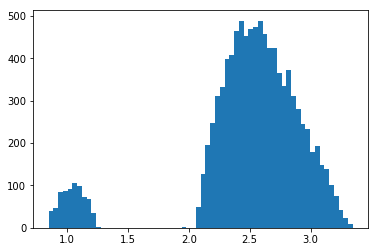

In [43]:
plt.hist(data, bins=64);

In [44]:
from sklearn.mixture import BayesianGaussianMixture

In [52]:
n = 20
gm = BayesianGaussianMixture(n_components=n, degrees_of_freedom_prior=20, max_iter=20000, tol=1e-5)
gm.fit(data.reshape(-1, 1))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=20, init_params='kmeans',
            max_iter=20000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=1e-05, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [53]:
x_plot = np.linspace(np.log10(0.3), np.log10(6000), 200)
t2_pdf = t2.pdf(x_plot)

In [54]:
components = []
for i in range(n):
    components.append(gm.weights_[i]*stats.norm.pdf(x_plot, gm.means_[i], np.sqrt(gm.covariances_[i])).flatten())
components = np.transpose(components)

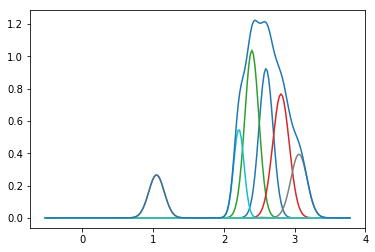

In [55]:
plt.plot(x_plot, components);
plt.plot(x_plot, np.sum(components, axis=1));

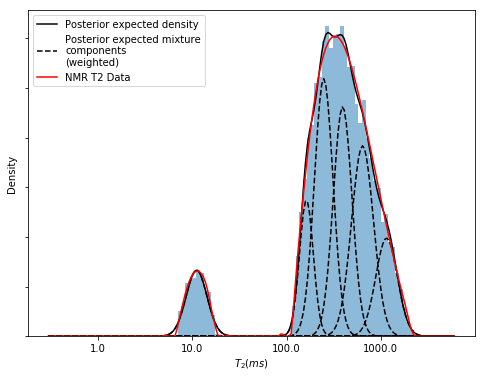

In [56]:
from collections import OrderedDict

fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.hist(data, bins=64, normed=True, lw=0, alpha=0.5)
ax3.plot(x_plot, np.sum(components, axis=1), color='k', label='Posterior expected density')
ax3.plot(x_plot, components, '--', color='k', label='Posterior expected mixture\ncomponents\n(weighted)')
ax3.plot(x_plot, t2_pdf, color='r', label="NMR T2 Data")
ax3.set_xticklabels(10 ** np.array(ax3.get_xticks().tolist()))
ax3.set_xlabel('$T_{2} (ms)$')
ax3.set_yticklabels([])
ax3.set_ylabel('Density')
ax3.legend(loc=2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [57]:
gm.weights_

array([  2.30109724e-01,   7.32827867e-02,   2.57703286e-01,
         2.23093660e-01,   4.87457890e-04,   4.66935310e-04,
         4.62117589e-04,   1.13457593e-01,   4.48055832e-04,
         1.00483405e-01,   4.74079978e-06,   2.25752370e-07,
         1.07501129e-08,   5.11910137e-10,   2.43766732e-11,
         1.16079396e-12,   5.52759029e-14,   2.63218585e-15,
         1.25342183e-16,   5.96867540e-18])

In [58]:
gm.weight_concentration_

(array([  2.30133886e+03,   7.33000000e+02,   2.57800812e+03,
          2.23228918e+03,   4.87979300e+00,   4.67651622e+00,
          4.63041592e+00,   1.13737371e+03,   4.49604605e+00,
          1.00930736e+03,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([  7.69971114e+03,   6.96771114e+03,   4.39070302e+03,
          2.15941385e+03,   2.15553405e+03,   2.15185754e+03,
          2.14822712e+03,   1.01185341e+03,   1.00835736e+03,
          5.00000007e-02,   5.00000000e-02,   5.00000000e-02,
          5.00000000e-02,   5.00000000e-02,   5.00000000e-02,
          5.00000000e-02,   5.00000000e-02,   5.00000000e-02,
          5.00000000e-02,   5.00000000e-02]))